<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import os
from IPython.display import Markdown
import numpy as np

from tqdm import notebook
import re
import transformers

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = '/Users/Саркисян Александр/Desktop/practicum_ds/ml/ml_for_texts/toxic_comments.csv'
pth3 = '/Users/Alex/Desktop/practicum_ds/ml/ml_for_texts/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data = pd.read_csv(pth3)
else:
    print('Something is wrong')

**Информация о выборке:**

In [3]:
def about_df(df):
    display(Markdown('**HEAD**'))
    display(df.head())
    print('\n')
    display(Markdown('**INFO**'))
    display(df.info())
    print('\n')
    display(Markdown('**ISNA**'))
    display(df.isna().sum())
    print('\n')
    display(Markdown('**DESCRIBE**'))
    display(df.describe())
    print('\n')
    display(Markdown('**CORR**'))
    display(df.corr())
    print('\n')
    display(Markdown('**DUPLICATES**'))
    print('Дубликаты =', df.duplicated().sum())

In [4]:
about_df(data)

**HEAD**

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**INFO**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

**ISNA**

text     0
toxic    0
dtype: int64

**DESCRIBE**

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**CORR**

,toxic
toxic,1.0


**DUPLICATES**

Дубликаты = 0


**Вывод:**
    
Таблица состоит из 2 столбцов: 
- text — текст комментария

Целевой признак:
- toxic — является ли комментарий токсичным = 1 или нет = 0

Пропуски и дубликаты отсутствуют.

Далее идет подготовка данных для обучения.

**Создадим корпус постов.**

In [5]:
# Преобразуем столбец 'text' в список текстов. 
# Переведём тексты в стандартный для Python формат: кодировку Unicode U
corpus = data['text'].values

**Очистим и лемитизируем текст.**

In [6]:
def lemmatize(text):
    m = WordNetLemmatizer()
    lemm_list = [m.lemmatize(w) for w in text]
    lemm_text = "".join(lemm_list)
        
    return lemm_text


def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(text.split())

In [7]:
for i in notebook.tqdm(range(len(corpus))):
    corpus[i] = lemmatize(clear_text(corpus[i]))

  0%|          | 0/159571 [00:00<?, ?it/s]

**Добавим в data столбец vector_text с очищенными и лемматизированными текстами.**

In [8]:
corpus_df = pd.DataFrame(corpus)
data['lemm_text'] = corpus_df[0]
data.head(10)

,text,toxic,lemm_text
0,Explanation Why the edits made under my userna...,0,Explanation Why the edits made under my userna...
1,D aww He matches this background colour I m se...,0,D aww He matches this background colour I m se...
2,Hey man I m really not trying to edit war It s...,0,Hey man I m really not trying to edit war It s...
3,More I can t make any real suggestions on impr...,0,More I can t make any real suggestions on impr...
4,You sir are my hero Any chance you remember wh...,0,You sir are my hero Any chance you remember wh...
5,Congratulations from me as well use the tools ...,0,Congratulations from me as well use the tools ...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word nonsense was offensive to yo...,0,Sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


**Проверка баланса классов выборки**

0    0.898321
1    0.101679
Name: toxic, dtype: float64


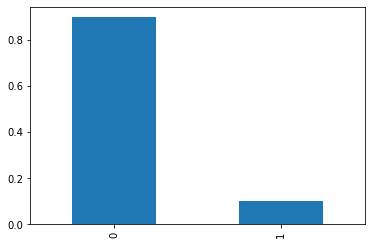

In [9]:
df_class_frequency = data['toxic'].value_counts(normalize=True)
print(df_class_frequency)
df_class_frequency.plot(kind='bar');

Существенный дисбаланс классов. Около 90% выборки приходится на значение 0 в целевом признаке.

**Формирование выборок:**

- обучающая 60%

- валидационная 20% для выбора оптимальных параметров

- тестовая 20% для теста лучшей модели.

In [10]:
df_train, df_valid_plus_test = train_test_split(
    data,
    test_size=0.40,
    random_state=12345,
    stratify=data['toxic'])

In [11]:
df_valid, df_test = train_test_split(
    df_valid_plus_test,
    test_size=0.5,
    random_state=12345,
    stratify=df_valid_plus_test['toxic'])

In [12]:
features_train = df_train.drop(['toxic'], axis=1)
target_train = df_train['toxic']

features_valid = df_valid.drop(['toxic'], axis=1)
target_valid = df_valid['toxic']

features_test = df_test.drop(['toxic'], axis=1)
target_test = df_test['toxic']

**Уберем стоп-слова, то есть слова без смысловой нагрузки.**

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


**Вычислим TF-IDF для корпуса текстов, т.е. сделаем вектаризацию текста**

In [14]:
corpus_df_train = features_train['lemm_text'].values
corpus_df_valid = features_valid['lemm_text'].values
corpus_df_test = features_test['lemm_text'].values

In [15]:
tf_idf_train = count_tf_idf.fit_transform(corpus_df_train)
tf_idf_valid = count_tf_idf.transform(corpus_df_valid)
tf_idf_test = count_tf_idf.transform(corpus_df_test)

In [16]:
print(tf_idf_train.shape)
print(tf_idf_valid.shape)
print(tf_idf_test.shape)

(95742, 125014)
(31914, 125014)
(31915, 125014)


## Обучение

**LogisticRegression**

Подберем параметры, которые максимизируют значения F1 на валидационной выборке для LogisticRegression

In [17]:
seed=2

def objective(params):
    
    c = int(params['C'])
    max_iter = int(params['max_iter'])
    
    model=LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear', C = c, max_iter = max_iter)
    model.fit(tf_idf_train, target_train)
    pred=model.predict(tf_idf_valid)
    score = -f1_score(target_valid, pred)
    return score

def optimize(trial):
    params={'C':hp.uniform('C', 5, 20),
            'max_iter':hp.uniform('max_iter', 1000, 2000)}
    
    
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=50,rstate=np.random.default_rng(seed))
    
    return best

trial=Trials()
best=optimize(trial)

100%|███████████████████████████████████████████████| 50/50 [01:33<00:00,  1.88s/trial, best loss: -0.7715355805243446]


По итогам подбора получены параметры, которые максимизируют значения F1 на валидационной выборке для LogisticRegression

In [18]:
best

{'C': 15.865609629994768, 'max_iter': 1033.7338237463564}

Обучим модель LogisticRegression для полученных параметров и замерим время обучения

In [19]:
%%time
LogR_model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear', C = 16, max_iter = 1034)
LogR_model.fit(tf_idf_train, target_train)

Wall time: 1.64 s


LogisticRegression(C=16, class_weight='balanced', max_iter=1034,
                   random_state=12345, solver='liblinear')

Получим предсказания на тестовой выборке и замерим время

In [20]:
%%time
LogR_pred=LogR_model.predict(tf_idf_test)

Wall time: 4.43 ms


In [21]:
f1_LogR = f1_score(target_test, LogR_pred).round(3)
print('F1 на тестовой выборке для LogisticRegressor:', f1_LogR)

F1 на тестовой выборке для LogisticRegressor: 0.768


**LGBMClassifier**

Подберем параметры, которые максимизируют значения F1 на валидационной выборке для LGBMClassifier

In [22]:
seed=2

def objective(params):
    
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
            
    model=LGBMClassifier(random_state=12345, n_estimators=est, max_depth=md, class_weight='balanced')
    model.fit(tf_idf_train, target_train)
    pred=model.predict(tf_idf_valid)
    score = -f1_score(target_valid, pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators', 400, 1000),
           'max_depth':hp.uniform('max_depth', 20, 50)}
    
    
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=50,rstate=np.random.default_rng(seed))
    
    return best

trial=Trials()
best=optimize(trial)

100%|█████████████████████████████████████████████| 50/50 [1:16:27<00:00, 91.76s/trial, best loss: -0.7737468011440614]


По итогам подбора получены параметры, которые максимизируют значения F1 на валидационной выборке для LGBMClassifier

In [23]:
best

{'max_depth': 25.879404692095942, 'n_estimators': 823.6036493252582}

Обучим модель LGBMClassifier для полученных параметров и замерим время обучения

In [24]:
%%time
LGBM_model = LGBMClassifier(n_estimators=824,max_depth=26)
LGBM_model.fit(tf_idf_train, target_train)

Wall time: 1min 37s


LGBMClassifier(max_depth=26, n_estimators=824)

Получим предсказания на тестовой выборке и замерим время

In [25]:
%%time
LGBM_pred=LGBM_model.predict(tf_idf_test)

Wall time: 1.73 s


In [26]:
f1_LGBM = f1_score(target_test, LGBM_pred).round(3)
print('F1 на тестовой выборке для LGBMClassifier:', f1_LGBM)

F1 на тестовой выборке для LGBMClassifier: 0.769


## Выводы

In [27]:
col = ['model', 'time_to_fit', 'f1']
LogR = ['LogisticRegression', '1.64s', f1_LogR]
LGBM = ['LGBMClassifier', '1m 37s', f1_LGBM]

table = pd.DataFrame([LogR, LGBM], columns = col)

display(table)

,model,time_to_fit,f1
0,LogisticRegression,1.64s,0.768
1,LGBMClassifier,1m 37s,0.769


**Лушчий показатель время-качество у модели LogisticRegression**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны